In [7]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 

* 손실함수 : 결과값을 가장 작게 만드는 함수 가중치 매개변수를 찾을떄 사용 

# 4.1 데이터 학습

규칙을 ‘사람’이 만드는 방식 ‘기계’가 데이터로부터 규칙(특징)을 발견해 내는 방식으로 패러다임 전환

## 4.1.1 데이터 주도학습
특징을 추출하고 벡터가 가지는 가중치를 부여

종단간 기계학습(end-to-end machine learning) : 처음부터 끝까지 입력에서 결과를 얻는다. 

## 4.1.2 훈련데이터와 시험데이터 
범용능력을 평가하기 위해서 train, test 데이터 분리 

# 4.2 손실함수 
loss function : 최적의 매겨변수 값을 탐색 

평균 제곱 오차, 교차 엔트로피 오차 사용


## 4.2.1 평균 제곱 오차 

mean squared error MSE : 각 원소의 출력(추정) 값과 정답 레이블의 차를 제곱한 후 그 총합 

one hot encoding: 한원소만 1로 하고 그외는 0으로 나타내는 표기범


In [8]:
import numpy as np 

def mean_squared_error(y, t):
    return 0.5 * np.sum((y-t)**2)

In [9]:
t = [0,0,1,0,0,0,0,0,0,0]
y = [0.1,0.2,0.7,0.2,0.1,0,0,0,0,0]

print(mean_squared_error(np.array(y), np.array(t)))

t = [0,0,1,0,0,0,0,0,0,0]
y = [0.1,0.2,0.7,0.2,0.1,0,0.8,0,0,0]
print(mean_squared_error(np.array(y), np.array(t)))

0.095
0.415


오답에 가까울 수록 결과가 크다.

## 4.2.2 교차 엔트로피 
cross entroypy CEE : 정답에 해당하는 인덱스만 1 log 를 곱해도 나머진 모두 0이므로 결과에 영향을 주지 않는다. 정답일떄의 출력이 전체 값을 정함

정답에 해당하는 출력이 커질수록 0에 다가가다가 출력이 1일떄 0이 됨, 반대로 정답일때의 출력이 작아질수록 오차는 커짐

- 정보엔트로피 : 현재 사건에 대한 정보량 (정보량이 많다. = 선택사항이 많다. = 불확실 하다. = 복잡성, 불확정성)
- 교차엔트로피 (자연로그) : 두 확률 간의 엔트로피 (두확률간에 복잡도가 얼마나 높은지, 오차가 얼마나 많은지)


In [10]:
def cross_entropy_error(y, t):
    delta = 1e-7
    return -np.sum(t*np.log(y+delta))

# np.log(0) 이면 -inf 가 되어 계산을 진행할수 없음 0이 되지 않도록 해줌 

In [11]:
t = [0,0,1,0,0,0,0,0,0,0]
y = [0.1,0.2,0.7,0.2,0.1,0,0,0.1,0.2,0]
print(cross_entropy_error(np.array(y), np.array(t)))

y = [0.1,0.2,0.5,0.2,0.1,0,0.8,0,0,0]
print(cross_entropy_error(np.array(y), np.array(t)))

0.356674801082
0.69314698056


오차가 작은 처번째 추정이 정답일 가능성이 높다고 판단

## 4.2.3 미니배치 학습

모두에 대한 손실 함수의 합을 구함 평균 손실 함수 

일부만 골라서 학습 미니배치 학습 

test 한건당 평균 오차 

In [14]:
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 
import numpy as np
import pickle
from tmp.dataset.mnist import load_mnist
from common.functions import sigmoid, softmax

(x_train, t_train), (x_test, t_test) = load_mnist(normalize =True, one_hot_label=True)

print(x_train.shape)
print(t_train.shape)

(60000, 784)
(60000, 10)


In [16]:
# 훈련 데이터에서 무작위로 10장만 뺌 np.random.choice 이용
train_size = x_train.shape[0]
batch_size = 10
batch_mask = np.random.choice(train_size, batch_size)
x_batch = x_train[batch_mask]
t_batch = t_train[batch_mask]
x_batch[0:10]
t_batch[0]

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32)

array([ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.])

In [17]:
np.random.choice(60000, 10)

array([35983, 53085, 12898, 30921,  9693,  2657, 45665,  6457,   993, 43959])

## 4.2.4 (배치용) 교차 엔트로피 오차 구현하기 

데이터 하나당 교차 엔트로피 오차를 구하는 경우 reshape 함수로 데이터 shape 을 바꿈
배치크기로 나눠 정규화를 하고 이미지 1장단 평균의 교차 엔트로피 오차를 계산


In [25]:
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    batch_size = y.shape[0]
    return -np.sum(t*np.log(y))/batch_size

In [26]:
from tmp.ch03 import neuralnet_mnist
network = neuralnet_mnist.init_network()
y = neuralnet_mnist.predict(network, x_batch)
cross_entropy_error(y, t_batch)

0.21815200513228775

In [27]:
# one-hot 이 아닌 숫자 레이블일 경우 
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t]))/batch_size

In [28]:
batch_size
t
np.arange(batch_size)
y[np.arange(batch_size), t]
# np.arange(batch_size) row / t column

10

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

array([  5.24714182e-04,   1.59779377e-03,   7.48113889e-05,
         6.39280770e-04,   9.94004071e-01,   4.35634895e-04,
         1.87226001e-03,   9.97999232e-05,   7.29477335e-07,
         2.27661990e-02], dtype=float32)

* np.log(y[arange(batch_size), t])  설명<br>
0 부터 batch_size-1 까지 배열을 생성 <br>
각 데이터 정답 레이블에 해당하는 신경망의 출력을 추출 <br>
예) [y[0,2],y[1,7],y[3,9],y[4,4]]

In [44]:
cross_entropy_error(y, [3])

232.84817245588638

In [35]:
# 두가지를 한번에
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 훈련 데이터가 원핫벡터라면 정답 레이블의 인덱스로 반환
    if t.size == y.size:
        t = t.argmax(axis=1)
        
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t]))/batch_size

## 4.2.5 왜 손실 함수를 설정하는가?

손실함수의 미분 : 가중치 매개변수의 값을 아주 조금 변화시켰을때, 손실함수가 어떻게 변하냐 <br>
음수면 가중치 매개변수를 양으로 양이면 음수로 변화 시킴 <br>
미분 값이 0 이면 멈춤 <br>

계단 함수의 경우 미분한 값이 대부분 0 시그모이드는 연속적으로 변함 <br>
기울기가 0이 되지 않아 올바르게 학습할 수 있다. 

# 4.3 수치 미분

경사법 기울기(경사) 값을 기준으로 나아가야 하는 방향 

## 4.3.1 미분


In [10]:
def numerical_diff(f,x):
    h=10e-50
    return (f(x+h)-f(x))/h

문제점1) 반올림 오차 소숫점 8자리 이하는 생략되어 0이 되버림 (float32 0이되버림) > 1e-4 사용 <br>
문제점2) 차분 x+h 와 x 사이의 기울기에 해당됨 x 의 진정한 접선이 아니다. 

x+h 와 x-h 를 사용하여 x 를 중심으로 전후 차분을 계산 : **중심차분(중앙차분) **

In [29]:
def numerical_diff(f,x):
    h=1e-4 #0.001
    return (f(x+h)-f(x-h))/(2*h)

## 4.3.2 수치미분의 예

In [30]:
def function_1(x):
    return 0.01*x**2 + 0.1*x

In [31]:
def tangent_line(f, x):
    a = numerical_diff(f,x)
    b = f(x)-a*x
    return lambda t:a*t+b

array([-0.25, -0.23, -0.21, -0.19, -0.17, -0.15, -0.13, -0.11, -0.09,
       -0.07, -0.05, -0.03, -0.01,  0.01,  0.03,  0.05,  0.07,  0.09,
        0.11,  0.13,  0.15,  0.17,  0.19,  0.21,  0.23,  0.25,  0.27,
        0.29,  0.31,  0.33,  0.35,  0.37,  0.39,  0.41,  0.43,  0.45,
        0.47,  0.49,  0.51,  0.53,  0.55,  0.57,  0.59,  0.61,  0.63,
        0.65,  0.67,  0.69,  0.71,  0.73,  0.75,  0.77,  0.79,  0.81,
        0.83,  0.85,  0.87,  0.89,  0.91,  0.93,  0.95,  0.97,  0.99,
        1.01,  1.03,  1.05,  1.07,  1.09,  1.11,  1.13,  1.15,  1.17,
        1.19,  1.21,  1.23,  1.25,  1.27,  1.29,  1.31,  1.33,  1.35,
        1.37,  1.39,  1.41,  1.43,  1.45,  1.47,  1.49,  1.51,  1.53,
        1.55,  1.57,  1.59,  1.61,  1.63,  1.65,  1.67,  1.69,  1.71,
        1.73,  1.75,  1.77,  1.79,  1.81,  1.83,  1.85,  1.87,  1.89,
        1.91,  1.93,  1.95,  1.97,  1.99,  2.01,  2.03,  2.05,  2.07,
        2.09,  2.11,  2.13,  2.15,  2.17,  2.19,  2.21,  2.23,  2.25,
        2.27,  2.29,

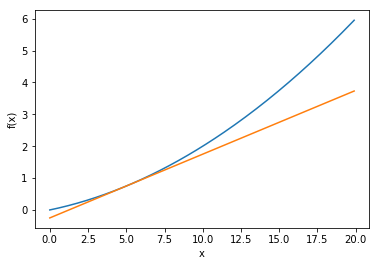

In [34]:
import numpy as np
import matplotlib.pylab as plt

x = np.arange(0.0, 20.0, 0.1)
y = function_1(x)

tangent = tangent_line(function_1, 5)
tl = tangent(x)
tl

plt.xlabel("x")
plt.ylabel("f(x)")
plt.plot(x,y)
plt.plot(x,tl)
plt.show()

In [14]:
# 5일떄 변화량
numerical_diff(function_1, 5)

0.1999999999990898

In [15]:
# 10일떄 변화량
numerical_diff(function_1, 10)

0.2999999999986347

## 4.3.3 편미분
partial differentiation

In [37]:
def function_2(x):
    return x[0]**2 + x[1]**2 #np.sum(x**2)

In [38]:
# x0=3 x1=4 x0 에 대한 편미분
def function_tmp1(x):
    return x*x + 4.0**2.0
numerical_diff(function_tmp1, 3.0)

6.00000000000378

In [39]:
# x0=3 x1=4 x1 에 대한 편미분
def function_tmp1(x):
    return  3.0**2.0+x*x
numerical_diff(function_tmp1, 4.0)

7.999999999999119

# 4.4 기울기 (gradient)

모든 변수의 평미분을 벡터로 정리

In [40]:
# 모든 변수의 편미분 (기울기) 값 구하기 
def numerical_gradient(f, x):
    h = 1e-4
    grad = np.zeros_like(x) # k 와 shape 이 같은 0배열을 생성 
    
    for idx in range(x.size):
        tmp_val = x[idx]
        
        # f(x+h) 계산
        x[idx] = tmp_val + h
        fxh1 = f(x)
        
        # f(x-h) 계산
        x[idx] = tmp_val - h 
        fxh2 = f(x) 
        
        grad[idx] = (fxh1 - fxh2) / (2*h)
        x[idx] = tmp_val # 값 복원
        
    return grad

In [41]:
print(numerical_gradient(function_2, np.array([3.0, 4.0])))
print(numerical_gradient(function_2, np.array([0.0, 2.0])))
print(numerical_gradient(function_2, np.array([3.0, 0.0])))

[ 6.  8.]
[ 0.  4.]
[ 6.  0.]


기울기가 가리키는 쪽: 각 장소에서 함수의 출력 값을 가장 줄이는 방향 (최소값)

## 4.4.1 경사 하강법
최적의 매개변수 찾기 

* 극소값, 최소값, 안장점 (sddle point) 이 되는 장소에서는 기울기가 0 
    * 복잡하고 찌그러진 모양의 함수라면 평평한곳으로 파고들면 고원(plateau) 라는 학습이 진행되지 않는 정체기에 빠질수 있다.
    
* 경사법 : 기울기를 구하고 -> 기울어진 방향으로 일정 거리만큼 이동 반복 
    * 학습률 : 매개변수 값을 얼마나 갱신할지 갱신하는 양 
    
현재 상태 = 이전 상태 - 경사

In [42]:
def gradient_descent(f, init_x, lr = 0.01, step_num = 100):
    x = init_x
    for i in range(step_num):
        grad = numerical_gradient(f, x)
        x -= lr * grad
    return x

In [43]:
def function_2(x):
    return x[0]**2 + x[1]**2

init_x = np.array([-3.0, 4.0])
gradient_descent(function_2, init_x=init_x, lr=0.1, step_num=100)

array([ -6.11110793e-10,   8.14814391e-10])

In [34]:
# 학습률이 너무 큰 경우 
init_x = np.array([-3.0, 4.0])
gradient_descent(function_2, init_x=init_x, lr=10.0, step_num=100)

array([ -2.58983747e+13,  -1.29524862e+12])

큰 값으로 발산해버림

In [35]:
# 학습률이 너무 작은 경우 
init_x = np.array([-3.0, 4.0])
gradient_descent(function_2, init_x=init_x, lr=1e-10, step_num=100)

array([-2.99999994,  3.99999992])

거의 갱신되지 않은 채로 끝남 

numpy 의 array 는 list와 다르게 [:] 복제가 x = init_x  아닌 init_x.copy() 로 해야 init_x 값이 변하지 않는다. 

* 하이퍼파라미터 : 학습률 같은 매개변수<br> 
    가중치, 편향 같은 매개변수는 훈련 데이터와 학습 알고리즘에 의해 자동으로 획득<br> 
    하이퍼파라미터는 직접 설정해줘야함 

## 4.4.2 신경망의 기울기 

가중치 매개변수에 관한 손실함수의 기울기 <br>
W 가 조금 변경했을 떄 손실함수 L 이 얼마나 변화하느냐 

In [36]:
# 신경망 기울기 구하기 
# x 입력 데이터, t 정답 레이블 
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
from common.functions import softmax, cross_entropy_error
from common.gradient import numerical_gradient

class simpleNet:
    # 2 * 3 가중치 매개변수
    def __init__(self):
        self.W = np.random.randn(2,3) # 정규분포로 초기화

    # 예측함수
    def predict(self, x):
        return np.dot(x, self.W)

    #손실함수
    def loss(self, x, t):
        z = self.predict(x)
        y = softmax(z)
        loss = cross_entropy_error(y, t)

        return loss

In [37]:
net = simpleNet()
print(net.W)

[[ 0.48310344  1.90941639 -0.10516501]
 [ 0.68532831  0.45945631 -0.85851639]]


In [39]:
x = np.array([0.6, 0.9])
p = net.predict(x)
print(p)

np.argmax(p)

[ 0.90665754  1.55916052 -0.83576375]


1

In [40]:
t = np.array([0,0,1])
net.loss(x, t)

2.8723504888714944

In [41]:
# numerical_gradient 내부에서 f(x) 를 실행 -> 일관성을 위해서 f(W) 를 정의
f = lambda w: net.loss(x, t)
dW = numerical_gradient(f, net.W)

print(dW)

[[ 0.19383368  0.37222683 -0.56606051]
 [ 0.29075052  0.55834025 -0.84909077]]


# 4.5 학습 알고리즘 구현하기

* 전제 <br>
    가중치와 편향을 훈련데이터에 적응하는 과정 : 학습
    
* 1단계-미니배치 <br>
    훈련데이터중에 일부 무작위로 선별 
    
* 2단계-기울기 산출 <br>
    손실함수 값을 줄이기 위해 가중치 매개변수의 기울기 구함 손실 함수를 작게하는 방향을 구함
    
* 3단계-매개변수 갱신 <br>
    가중치 매개변수를 기울기 방향으로 갱신 
    
* 4단계-반복


* **SGD** 확률적 경사 하강법 (stochastic gradient descent) <br>
    확률 적으로 무작위로 골라낸 데이터 로 하는 경사하강법
    
## 4.5.1 2층 신경망 클래스 구현

In [45]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
from common.functions import *
from common.gradient import numerical_gradient


class TwoLayerNet:

    # 입력충의 뉴런수, 은닉층의 뉴런수, 출력층의 뉴런수
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        # 가중치 초기화
        self.params = {}
        # 1층의 가중치 
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        # 2층의 가중치 
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

    # 예측 : 이미지 데이터
    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
    
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        return y
        
    # 손실함수값 x : 입력 데이터, t : 정답 레이블
    def loss(self, x, t):
        y = self.predict(x)
        
        return cross_entropy_error(y, t)
    
    # 예측 정확도
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    # 가중치 매개변수 기울기 x : 입력 데이터, t : 정답 레이블
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        # 1층 가중치의 기울기
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        # 2층 가중치의 기울기
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
    
    # numerical_gradient 개선판 
    def gradient(self, x, t):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        grads = {}
        
        batch_num = x.shape[0]
        
        # forward
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        # backward
        dy = (y - t) / batch_num
        grads['W2'] = np.dot(z1.T, dy)
        grads['b2'] = np.sum(dy, axis=0)
        
        da1 = np.dot(dy, W2.T)
        dz1 = sigmoid_grad(a1) * da1
        grads['W1'] = np.dot(x.T, dz1)
        grads['b1'] = np.sum(dz1, axis=0)

        return grads

In [47]:
# 신경망에 필요한 매개변수 저장
net = TwoLayerNet(input_size=784, hidden_size=100, output_size=10)
print(net.params['W1'].shape)
print(net.params['b1'].shape)
print(net.params['W2'].shape)
print(net.params['b2'].shape)

(784, 100)
(100,)
(100, 10)
(10,)


In [48]:
# 매개변수 예측 처리 (순방향)
x = np.random.rand(100, 784) # 더미 입력 데이터 100장 
y = net.predict(x)
y

array([[ 0.09707189,  0.10129189,  0.091523  ,  0.10397075,  0.10806044,
         0.10069367,  0.09483567,  0.10361215,  0.10201987,  0.09692066],
       [ 0.09649269,  0.10144229,  0.09199072,  0.10416948,  0.10794061,
         0.10037948,  0.0949145 ,  0.10356521,  0.10195219,  0.09715284],
       [ 0.09674049,  0.10138959,  0.09156471,  0.10402363,  0.10807387,
         0.10040011,  0.09511323,  0.10378822,  0.10188773,  0.09701841],
       [ 0.09702121,  0.10136123,  0.09162577,  0.1037925 ,  0.10793477,
         0.10064575,  0.09508692,  0.10405596,  0.10167748,  0.09679841],
       [ 0.09684844,  0.10175652,  0.09155922,  0.10401971,  0.10781472,
         0.10028806,  0.09480651,  0.10373731,  0.10210824,  0.09706128],
       [ 0.09699031,  0.10150254,  0.09134974,  0.10407549,  0.10833824,
         0.10052274,  0.09488384,  0.10347607,  0.10185495,  0.09700608],
       [ 0.09716164,  0.10132076,  0.09149925,  0.10379206,  0.10817238,
         0.10027034,  0.09480523,  0.10376656

In [49]:
# 기울기 계산
x = np.random.rand(100, 784) # 더미 입력 데이터 (100장)
t = np.random.rand(100, 10) # 더미 정답 데이터 (100장)

grads = net.numerical_gradient(x,t)

print(grads['W1'].shape)
print(grads['b1'].shape)
print(grads['W2'].shape)
print(grads['b2'].shape)

(784, 100)
(100,)
(100, 10)
(10,)


## 4.5.2 미니배치 학습 구현

In [50]:
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from tmp.dataset.mnist import load_mnist

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)
print(net.params['W1'].shape)
print(net.params['b1'].shape)
print(net.params['W2'].shape)
print(net.params['b2'].shape)

(784, 100)
(100,)
(100, 10)
(10,)


In [ ]:
# 하이퍼파라미터
iters_num = 10000  # 반복 횟수를 적절히 설정한다.
train_size = x_train.shape[0]
batch_size = 100   # 미니배치 크기
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

# 1에폭당 반복 수
iter_per_epoch = max(train_size / batch_size, 1)

60,000 개의 훈련데이터에서 임의 100개 데이터 추림 (이미지, 정답 데이터) <br>
확률 적으로 경사 하강법 수행으로 매개변수 갱신<br>
갱신 횟수 10,000 번 (반복횟수) <br>
갱신 시, 훈련데이터에 대한 손실함수계산, 배열에 추가 

In [53]:
for i in range(iters_num):
    # 미니배치 획득
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 기울기 계산
    #grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch)
    
    # 매개변수 갱신
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    # 학습 경과 기록
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    # 1에폭당 정확도 계산
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))


train acc, test acc | 0.0986333333333, 0.0958
train acc, test acc | 0.788166666667, 0.7918
train acc, test acc | 0.879333333333, 0.8826
train acc, test acc | 0.897816666667, 0.9012
train acc, test acc | 0.908966666667, 0.9118
train acc, test acc | 0.914733333333, 0.916
train acc, test acc | 0.92025, 0.9222
train acc, test acc | 0.924416666667, 0.9248
train acc, test acc | 0.928466666667, 0.9279
train acc, test acc | 0.93235, 0.9316
train acc, test acc | 0.934816666667, 0.935
train acc, test acc | 0.937483333333, 0.9376
train acc, test acc | 0.940166666667, 0.9389
train acc, test acc | 0.941966666667, 0.9399
train acc, test acc | 0.94375, 0.9419
train acc, test acc | 0.945783333333, 0.9448
train acc, test acc | 0.947166666667, 0.9456


## 4.5.3 시험 데이터로 평가 

* epoch : 학습에서 훈련 데이터를 모두 소진했을 떄의 횟수 (10,000개를 100개의 미지배치로 학습한 경우 100회 1epoch)

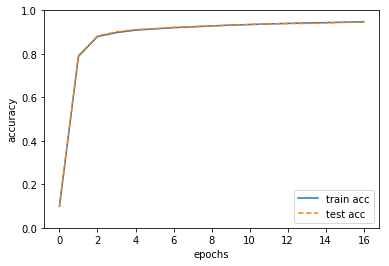

In [54]:
# 정확도 그래프 그리기
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()
